# Import Libraries

In [4]:
# Re-implement using pure shapely + rasterio (no geopandas) to avoid array-interface issues
import warnings
import sys
import geopandas as gpd
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import orient
import pathlib
import requests
import numpy as np
import pandas as pd

import shutil
import matplotlib.pyplot as plt

from dotenv import load_dotenv
import os
warnings.filterwarnings("ignore", category=UserWarning)

In [5]:
pth = pathlib.Path("G:/My Drive/OET_Milford")
dst_dir = pathlib.Path("G:/My Drive/Milford_OpenET")
# make sure the destination directory exists
dst_dir.mkdir(parents=True, exist_ok=True)

In [ ]:


for file in pth.rglob("*OpenET*ensemble_*.tif"):
    new_name = str(file.stem).split(" ")[-1] + file.suffix
    dst = dst_dir / new_name
    shutil.copy2(file, dst)  # preserves metadata like timestamps
    print(f"Copied {file} to {dst}")


Copied G:\My Drive\OET_Milford\OpenET Exports (72)\OpenET Exports ensemble_et_2000_07_01_0a376.tif to G:\My Drive\Milford_OpenET\ensemble_et_2000_07_01_0a376.tif
Copied G:\My Drive\OET_Milford\OpenET Exports (830)\OpenET Exports ensemble_et_2000_01_01_70e77.tif to G:\My Drive\Milford_OpenET\ensemble_et_2000_01_01_70e77.tif
Copied G:\My Drive\OET_Milford\OpenET Exports (159)\OpenET Exports ensemble_et_2000_09_01_590fd.tif to G:\My Drive\Milford_OpenET\ensemble_et_2000_09_01_590fd.tif
Copied G:\My Drive\OET_Milford\OpenET Exports (233)\OpenET Exports ensemble_et_2000_08_01_e0923.tif to G:\My Drive\Milford_OpenET\ensemble_et_2000_08_01_e0923.tif
Copied G:\My Drive\OET_Milford\OpenET Exports (704)\OpenET Exports ensemble_et_2000_03_01_44eea.tif to G:\My Drive\Milford_OpenET\ensemble_et_2000_03_01_44eea.tif
Copied G:\My Drive\OET_Milford\OpenET Exports (209)\OpenET Exports ensemble_et_2000_06_01_df0cf.tif to G:\My Drive\Milford_OpenET\ensemble_et_2000_06_01_df0cf.tif
Copied G:\My Drive\OET_

KeyboardInterrupt: 

In [6]:
# Compute masked-acre-feet summaries for ET, precipitation, and applied ET (within AOI mask).
# - Uses your AOI polygon: /mnt/data/oet_mask.gpkg
# - Pairs monthly rasters by YYYY_MM in filenames.
# - Computes totals within AOI on the ET grid for consistency.
#
# Inputs expected in /mnt/data:
#   ensemble_et_YYYY_MM_*.tif    (ET, mm/month)
#   gridmet_pr_YYYY_MM_*.tif     (PR, mm/month)
# Optional (already created):
#   /mnt/data/applied_water_out/applied_et_YYYY_MM_AGMASK.tif (for reference)

from pathlib import Path
import re
import numpy as np
import pandas as pd
import rasterio
from rasterio.warp import reproject, Resampling, transform_geom
from rasterio.features import rasterize
import fiona


DATA_DIR = dst_dir
OUT_DIR = DATA_DIR / "applied_water_out"
OUT_DIR.mkdir(parents=True, exist_ok=True)

mask_path = "oet_mask.gpkg"

# File discovery
et_keyword = "ensemble_et"
pr_keyword = "gridmet_pr"
month_re = re.compile(r"(?P<year>\d{4})[_\-](?P<month>\d{2})")

def month_key(p: Path):
    m = month_re.search(p.name)
    return f"{m.group('year')}-{m.group('month')}" if m else None

In [ ]:


et_files = {month_key(p): p for p in DATA_DIR.glob("*.tif") if et_keyword in p.name.lower() and month_key(p)}
pr_files = {month_key(p): p for p in DATA_DIR.glob("*.tif") if pr_keyword in p.name.lower() and month_key(p)}
months = sorted(set(et_files) & set(pr_files))
assert months, "No month overlap between ET and PR rasters found."

# Read AOI polygons
with fiona.open(mask_path) as vec:
    vec_crs = vec.crs_wkt or vec.crs
    geoms = [feat["geometry"] for feat in vec if feat.get("geometry")]
assert geoms, "No geometries found in AOI mask."

MM_TO_M = 1.0/1000.0
M3_PER_ACRE_FT = 1233.48184

def pixel_area_m2(transform, shape, crs):
    a = transform.a
    e = transform.e
    f = transform.f
    h, w = shape
    try:
        is_geo = crs.is_geographic
    except Exception:
        is_geo = True
    if not is_geo:
        return abs(a*e) * np.ones((h, w), dtype="float64")
    # geographic: vary with latitude
    rows = np.arange(h)
    lat = f + (rows + 0.5) * e
    lat_rad = np.deg2rad(lat)
    m_per_deg_lat = 111320.0
    m_per_deg_lon = 111320.0*np.cos(lat_rad)
    dlat_deg = abs(e)
    dlon_deg = abs(a)
    row_area = (m_per_deg_lat*dlat_deg) * (m_per_deg_lon*dlon_deg)
    return np.repeat(row_area[:, None], w, axis=1)

records = []

for key in months:
    try:
        et_path = et_files[key]
        pr_path = pr_files[key]
        print(f"Processing month {key}: ET={et_path.name}, PR={pr_path.name}")
        
        with rasterio.open(et_path) as et_ds:
            et = et_ds.read(1, masked=True).astype("float32")
            et_profile = et_ds.profile.copy()
            et_crs = et_ds.crs
            et_transform = et_ds.transform
            h, w = et.shape
            et_nodata = et_ds.nodata
            
            # Rasterize AOI to ET grid
            geoms_xf = [transform_geom(src_crs=vec_crs, dst_crs=et_crs.to_wkt() if hasattr(et_crs, "to_wkt") else et_crs, geom=g) for g in geoms]
            aoi_mask = rasterize(
                ((g, 1) for g in geoms_xf),
                out_shape=(h, w),
                transform=et_transform,
                fill=0,
                all_touched=False,
                dtype="uint8"
            ).astype(bool)
            
            # Reproject PR to ET grid
            with rasterio.open(pr_path) as pr_ds:
                pr = pr_ds.read(1, masked=True).astype("float32")
                dst = np.zeros((h, w), dtype="float32")
                
                reproject(
                    source=pr.filled(0.0),
                    destination=dst,
                    src_transform=pr_ds.transform,
                    src_crs=pr_ds.crs,
                    dst_transform=et_transform,
                    dst_crs=et_crs,
                    resampling=Resampling.bilinear,
                    src_nodata=pr_ds.nodata if pr_ds.nodata is not None else None,
                    dst_nodata=None,
                )
                # Validity for PR after reprojection
                valid_src = (~pr.mask).astype("uint8")
                valid_dst = np.zeros((h, w), dtype="uint8")
                reproject(
                    source=valid_src,
                    destination=valid_dst,
                    src_transform=pr_ds.transform,
                    src_crs=pr_ds.crs,
                    dst_transform=et_transform,
                    dst_crs=et_crs,
                    resampling=Resampling.nearest,
                )
                pr_on_et = np.ma.array(dst, mask=(valid_dst == 0))
            
            # AOI + validity masks
            et_valid = (~et.mask) & aoi_mask
            pr_valid = (~pr_on_et.mask) & aoi_mask
            
            # Combined validity
            valid = (~et.mask) & (~pr_on_et.mask) & aoi_mask
            
            # Applied ET [mm/month]
            applied = np.ma.array(np.zeros_like(et, dtype="float32"), mask=~valid)
            applied[valid] = et[et_valid] - pr_on_et[valid]*0.9
            applied[valid] = np.where(applied[valid] > 0, applied[valid], 0.0)
        
            # Write output raster
            out_raster = OUT_DIR / f"applied_et_{key.replace('-', '_')}.tif"
            out_profile = et_profile.copy()
            out_profile.update(dtype="float32", count=1, nodata=-9999.0, compress="lzw", tiled=True)
            with rasterio.open(out_raster, "w", **out_profile) as dst:
                dst.write(applied.filled(-9999.0).astype("float32"), 1)

            # Totals (mm to m, then * area)
            area = pixel_area_m2(et_transform, (h, w), et_crs)
            et_tot_m3 = float((et[et_valid] * MM_TO_M * area[et_valid]).sum())
            pr_tot_m3 = float((pr_on_et[pr_valid] * MM_TO_M * area[pr_valid]).sum())
            
            # Applied computed over pixels where BOTH valid within AOI
            both = et_valid & pr_valid
            applied_mm = np.maximum(et[both] - pr_on_et[both], 0.0)
            app_tot_m3 = float((applied_mm * MM_TO_M * area[both]).sum())
            
            records.append({
                "month": key,
                "et_acre_feet_masked": et_tot_m3 / M3_PER_ACRE_FT,
                "precip_acre_feet_masked": pr_tot_m3 / M3_PER_ACRE_FT,
                "applied_acre_feet_masked": app_tot_m3 / M3_PER_ACRE_FT,
                "et_pixels_in_aoi": int(et_valid.sum()),
                "pr_pixels_in_aoi": int(pr_valid.sum()),
                "both_valid_pixels": int(both.sum()),
                "et_file": et_path.name,
                "pr_file": pr_path.name,
            })

    except Exception as e:
        print(f"Error processing month {key}: {e}", file=sys.stderr)
        pass
df = pd.DataFrame.from_records(records).sort_values("month")
csv_path = OUT_DIR / "masked_et_pr_applied_acrefeet_summary.csv"
df.to_csv(csv_path, index=False)


Processing month 1990-01: ET=ensemble_et_1990_01_01_18205.tif, PR=gridmet_pr_1990_01_01_ddb16.tif
Processing month 1990-02: ET=ensemble_et_1990_02_01_945fa.tif, PR=gridmet_pr_1990_02_01_e3530.tif
Processing month 1990-03: ET=ensemble_et_1990_03_01_18f0a.tif, PR=gridmet_pr_1990_03_01_27e29.tif
Processing month 1990-04: ET=ensemble_et_1990_04_01_db8ad.tif, PR=gridmet_pr_1990_04_01_30a39.tif
Processing month 1990-05: ET=ensemble_et_1990_05_01_31f99.tif, PR=gridmet_pr_1990_05_01_44340.tif
Processing month 1990-06: ET=ensemble_et_1990_06_01_4678f.tif, PR=gridmet_pr_1990_06_01_e98d0.tif
Processing month 1990-07: ET=ensemble_et_1990_07_01_76cdb.tif, PR=gridmet_pr_1990_07_01_d4516.tif
Processing month 1990-08: ET=ensemble_et_1990_08_01_4644a.tif, PR=gridmet_pr_1990_08_01_6df9f.tif
Processing month 1990-09: ET=ensemble_et_1990_09_01_a007d.tif, PR=gridmet_pr_1990_09_01_35fec.tif
Processing month 1990-10: ET=ensemble_et_1990_10_01_1151f.tif, PR=gridmet_pr_1990_10_01_c4191.tif
Processing month 199

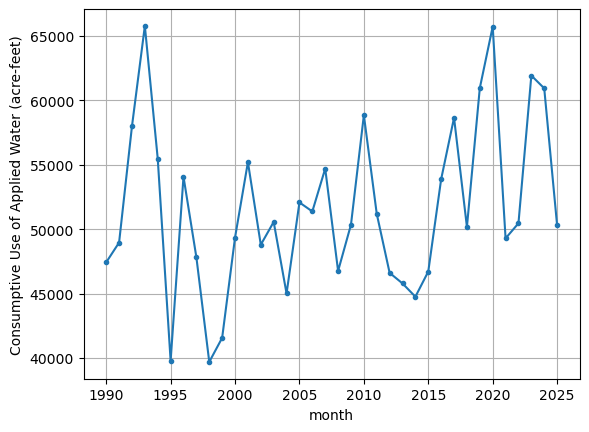

In [97]:
df['month'] = pd.to_datetime(df['month'])
adf = df.set_index(['month'])
adf = adf[adf.index.month.isin([4,5,6,7,8,9,10])]
yrdf = adf.groupby(adf.index.year).sum()
yrdf['applied_acre_feet_masked'].plot(marker='.')
plt.grid()
plt.ylabel('Consumptive Use of Applied Water (acre-feet)')
plt.savefig("consumptive_use_applied_et.pdf")
plt.savefig("consumptive_use_applied_et.png")

In [7]:
# Zonal statistics across *all months* for ET, Precip, and Applied (ET−P) using a GeoPackage with multiple polygons.
# - Loops over monthly rasters, pairing ET and PR by YYYY_MM in filenames.
# - Computes ET, PR (reprojected to ET grid), and Applied = max(ET−PR, 0) [all in mm/month].
# - For each polygon feature in the GPKG, computes stats: count, mean, median, sum, min, max, std.
# - Outputs a long-form CSV with one row per (month, polygon).
#
# File conventions in /mnt/data:
#   ensemble_et_YYYY_MM_*.tif    (ET, mm/month; target grid)
#   gridmet_pr_YYYY_MM_*.tif     (PR, mm/month; mm/month)
# AOI polygons (multiple features): /mnt/data/oet_mask.gpkg
#
# Result:
#   /mnt/data/applied_water_out/zonal_stats_monthly_polygons.csv
#
# You can adjust: stats_to_compute, all_touched, file patterns, etc.

from pathlib import Path
import re
import numpy as np
import pandas as pd
from rasterstats import zonal_stats
import geopandas as gpd



aoi_path = "gis_files/pou_oet.gpkg"
aois = gpd.read_file(aoi_path).to_crs(epsg=4326)

# File discovery helpers
et_keyword = "ensemble_et"
pr_keyword = "gridmet_pr"
month_re = re.compile(r"(?P<year>\d{4})[_\-](?P<month>\d{2})")

def month_key(p: Path):
    m = month_re.search(p.name)
    return f"{m.group('year')}-{m.group('month')}" if m else None

# Collect rasters
et_files = {month_key(p): p for p in DATA_DIR.glob("*.tif") if (et_keyword in p.name.lower()) and month_key(p)}
pr_files = {month_key(p): p for p in DATA_DIR.glob("*.tif") if (pr_keyword in p.name.lower()) and month_key(p)}
applied_files = {month_key(p): p for p in OUT_DIR.glob("*.tif") if ("applied_et" in p.name.lower()) and month_key(p)}

months = sorted(set(et_files) & set(pr_files) & set(applied_files))
assert months, "No overlapping months found for rasters."


rows = []
zonal = {}
for key in months:
    year = int(key.split("-")[0])
    mo = int(key.split("-")[1])
    if year >= 1990 and mo in [3,4,5,6,7,8,9,10,11]:
        et_path = et_files[key]
        pr_path = pr_files[key]
        applied_path = applied_files[key]
        print(f"Processing month {key}: Consumed={applied_path.name},") #ET={et_path.name}, PR={pr_path.name}, ")
        
        pths = {"consumed":applied_path} #"et":et_path, "precip":pr_path, }
        for lab, pth in pths.items():
            try:
                vals = zonal_stats(aois, pth, stats="mean", all_touched=True)
                results = [v['mean'] for v in vals]
                zonal[f"{key}-{lab}"] = results
            except Exception as e:
                print(f"Error processing {key}, {lab}: {e}")
                pass



Processing month 1990-03: Consumed=applied_et_1990_03.tif,
Processing month 1990-04: Consumed=applied_et_1990_04.tif,
Processing month 1990-05: Consumed=applied_et_1990_05.tif,
Processing month 1990-06: Consumed=applied_et_1990_06.tif,
Processing month 1990-07: Consumed=applied_et_1990_07.tif,
Processing month 1990-08: Consumed=applied_et_1990_08.tif,
Processing month 1990-09: Consumed=applied_et_1990_09.tif,
Processing month 1990-10: Consumed=applied_et_1990_10.tif,
Processing month 1990-11: Consumed=applied_et_1990_11.tif,
Processing month 1991-03: Consumed=applied_et_1991_03.tif,
Processing month 1991-04: Consumed=applied_et_1991_04.tif,
Processing month 1991-05: Consumed=applied_et_1991_05.tif,
Processing month 1991-06: Consumed=applied_et_1991_06.tif,
Processing month 1991-07: Consumed=applied_et_1991_07.tif,
Processing month 1991-08: Consumed=applied_et_1991_08.tif,
Processing month 1991-09: Consumed=applied_et_1991_09.tif,
Processing month 1991-10: Consumed=applied_et_1991_10.ti

: 

In [7]:
modata = pd.DataFrame.from_dict(zonal, orient="index").reset_index()
modata['month'] = modata['index'].str.split('-').str[0] + '-' + modata['index'].str.split('-').str[1]
modata['variable'] = modata['index'].str.split('-').str[2]
modata['month'] = pd.to_datetime(modata['month'])
modata = modata[modata['month'].dt.month.isin([4,5,6,7,8,9,10])]
modata = modata.groupby(['variable',modata['month'].dt.year]).sum(numeric_only=True).stack()#.unstack(0).unstack(0)#
modata.name = 'value' 
modata = 0.00328084 * modata * modata.index.get_level_values(-1).map(aois['ACRES'].to_dict())
modata = modata.round(1).reset_index().rename(columns={'level_2':'obid','month':'year'})
modata['var-year'] = modata['variable'] + '_' + modata['year'].astype(str)
modata = modata.drop(columns=['variable','year'])
modata = modata.set_index(['obid','var-year']).unstack().droplevel(0, axis=1)
modata

var-year,consumed_1994,consumed_1995,consumed_1996,consumed_1997,consumed_1998,consumed_1999,consumed_2000,consumed_2001,consumed_2002,consumed_2003,...,consumed_2016,consumed_2017,consumed_2018,consumed_2019,consumed_2020,consumed_2021,consumed_2022,consumed_2023,consumed_2024,consumed_2025
obid,,,,,,,,,,,,,,,,,,,,,
0,320.6,172.5,204.6,203.7,244.2,267.2,255.1,76.1,13.6,16.5,...,10.5,45.2,272.8,360.0,396.9,332.1,347.6,350.3,376.6,345.4
1,148.1,99.2,132.9,113.1,112.0,120.8,147.0,160.6,141.4,143.6,...,12.8,75.8,91.3,99.1,116.9,103.6,104.0,98.8,115.8,112.2
2,348.3,277.7,314.7,286.5,314.7,288.7,364.1,376.4,311.5,315.3,...,295.6,301.5,388.1,361.0,408.9,355.7,355.7,362.5,311.9,294.8
3,215.1,195.9,229.1,171.4,166.9,164.3,200.8,248.3,169.0,230.1,...,253.6,200.9,224.0,258.9,305.0,252.7,229.9,256.2,268.9,143.5
4,156.9,136.4,149.7,115.0,120.7,104.7,133.4,153.5,121.7,142.1,...,290.3,289.0,331.2,327.4,364.0,318.5,316.1,273.9,266.6,266.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,17.9,16.4,21.0,18.9,16.2,17.4,21.6,22.6,20.5,23.4,...,20.6,20.2,14.5,15.4,26.0,20.0,20.7,18.7,23.5,20.2
427,75.2,60.3,80.5,63.3,35.0,56.9,74.4,79.0,83.8,73.0,...,60.5,60.8,63.1,77.8,94.2,64.0,71.0,73.2,84.0,78.2
428,40.4,32.1,39.7,32.7,27.6,29.8,39.0,38.8,41.0,41.3,...,37.1,36.1,36.4,36.6,44.4,31.0,33.9,31.7,39.5,34.4


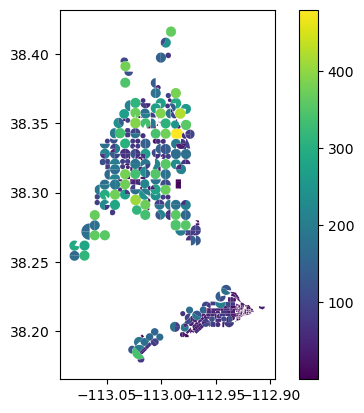

In [10]:
aoi_path = "gis_files/pou_oet.gpkg"
aois = gpd.read_file(aoi_path).to_crs(epsg=4326)
app_gis = pd.merge(aois, modata, left_index=True, right_index=True)
app_gis.plot(column='consumed_2024',legend=True)
app_gis.to_file("gis_files/pou_oet_consumed_1991_2025.gpkg")


In [11]:

gdf.columns

NameError: name 'gdf' is not defined

In [19]:
gdf = gpd.read_file("gis_files/pou_oet_applied_et_1991_2025.gpkg")
ws = gdf.groupby(['GROUP_NUMB']).WaterSourc.first().to_dict()
gdf = gdf.groupby('GROUP_NUMB').sum(numeric_only=True)
gdf['WaterSourc'] = gdf.index.map(ws)
gdf = gdf.rename(columns=lambda x: x.replace('applied_','efet_'))


ndvi = gpd.read_file("gis_files/pou_classified.gpkg")
ndvi.columns
ndvi = ndvi.groupby('GROUP_NUMB').agg({
                                'FARMNAME':'first',
                                'type':'first',
                                'peak_ndvi':'max',
                                'median_ndvi':'median',
                                'peak_date':'max',
                                'num_cuts':'max',
                                'pump_hrs':'mean',
                                'early_med':'median',
                                'late_med':'median'
                                }).round(2)
ndvi['watering_days'] = ndvi['pump_hrs'] / 24.0
ndvi = ndvi.drop(columns=['pump_hrs'])

fields = pd.merge(gdf, ndvi, left_index=True, right_index=True).round(2)
fields.to_csv("output_tables/fields_by_groupnumber_v2.csv")

In [ ]:
import pandas as pd
fields = pd.read_csv("output_tables/fields_by_groupnumber_v2.csv")
fields.columns
fields['pump_est_2024'] = fields['efet_2024']/0.70


well = pd.read_csv("output_tables/wells_with_properties.csv")
well = well[well['USES']=='I']
wells_w_field_info = pd.merge(well, fields, left_on='GROUP_NUMB', right_on='GROUP_NUMB')
wells_w_field_info.sort_values("GROUP_NUMB")
nowellsperfield = wells_w_field_info.groupby('GROUP_NUMB').size().to_dict()
wells_w_field_info['num_wells_per_field'] = wells_w_field_info['GROUP_NUMB'].map(nowellsperfield)
wells_w_field_info.drop(columns=['qtywtr',
                                 'AbandonDate',
                                 'proof_flow_gpm',
                                 'NewWellDate',],inplace=True)
wells_w_field_info.to_clipboard()